In [1]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats

from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import lightgbm as lgb
import optuna

In [2]:
# loading the train labels

labels_df = pd.read_csv('train_labels.csv')

labels_df['session'] = labels_df['session_id'].apply(lambda x: int(x.split('_')[0]))
labels_df['question'] = labels_df['session_id'].apply(lambda x: int(x.split('q')[1]))

labels_df = (
    labels_df
    .sort_values(by=['session', 'question'], ascending=[True, True])
    .reindex(columns=['session_id', 'session', 'question', 'correct'])
    .reset_index(drop=True)
    .drop(columns='session_id')
)

labels_df.head()

,session,question,correct
0,20090312431273200,1,1
1,20090312431273200,2,1
2,20090312431273200,3,1
3,20090312431273200,4,1
4,20090312431273200,5,1


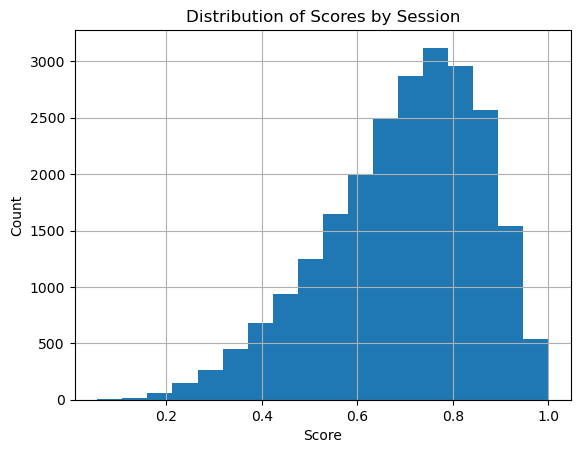

In [3]:
# the distribution of scores. it's almost definitely
# true that adding predictions from prior rounds
# will improve the model significantly. 

labels_df.groupby('session')['correct'].mean().hist(bins=18)

plt.title("Distribution of Scores by Session")

plt.ylabel("Count")
plt.xlabel("Score")

plt.show()

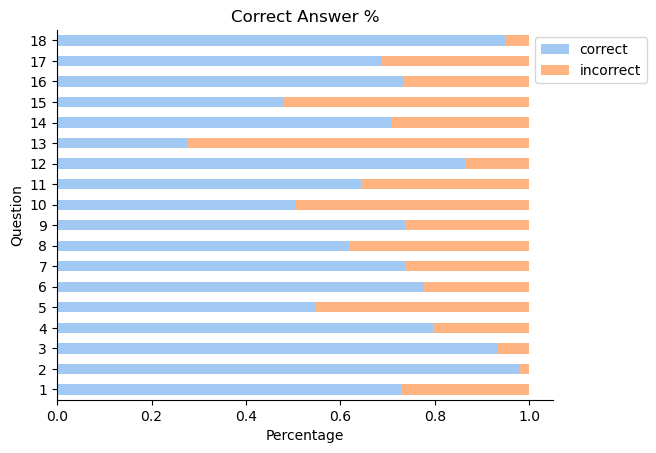

In [4]:
# calculating mean correct responses for each question
q_accuracy_df = labels_df.groupby('question')['correct'].mean().to_frame()
q_accuracy_df['incorrect'] = 1 - q_accuracy_df

# plotting the correct answer % by question
colors = sns.color_palette("pastel")

# horizontal barplot in seaborn with no spines
ax = q_accuracy_df.plot(kind='barh', stacked=True, color=colors, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Correct Answer %")
plt.xlabel("Percentage")
plt.ylabel("Question")

legend = plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left')
plt.show()

In [5]:
# excluding cols to save memory
exclude_cols = ['index', 'fullscreen', 'hq', 'music']

# borrowing the dtypes dictionary from a featured notebook
dtypes = {
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text': 'category',
    'fqid': 'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen': bool,
    'hq':bool,
    'music': bool,
    'level_group':'category'
}

df = pd.read_csv('train.csv', usecols=lambda x: x not in exclude_cols, dtype=dtypes)

df = (
    df
    .sort_values(by=['session_id', 'level', 'elapsed_time'], ascending=[True, True, True])
    .reset_index(drop=True)
)

# extracting date and time data from the session_id
df['year'] = df['session_id'].apply(lambda x: int(str(x)[:2]))
df['month'] = df['session_id'].apply(lambda x: int(str(x)[2:4]))
df['day'] = df['session_id'].apply(lambda x: int(str(x)[4:6]))
df['hour'] = df['session_id'].apply(lambda x: int(str(x)[6:8]))

# creating a weekend indicator because weekends are different
df['weekend'] = np.where(df['day'].isin([6,0]), 1, 0)

# simple distance calculation
df['room_distance'] = np.sqrt(df['room_coor_x'] ** 2 + df['room_coor_y'] ** 2)
df['screen_distance'] = np.sqrt(df['screen_coor_x'] ** 2 + df['screen_coor_y'] ** 2)

# simple manhattan distance calc (worked)
df['screen_manh_distance'] = abs(df['screen_coor_x']) + abs(df['screen_coor_y'])

In [ ]:
# inspecting a sample from the dataframe, i think calculating
# the amount of time in between opening and closing the notebook
# might be a good feature

# df['indicator_col'] = 0

# open_idx = df[df['name'] == 'open'].index
# close_idx = df[df['name'] == 'close'].index

# count = 1

# for start_idx in open_idx:
#     end_idx = close_idx[close_idx > start_idx].min()    
#     df.loc[start_idx:end_idx, 'indicator_col'] = count
    
#     count += 1

In [6]:
df.head()

,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,...,text_fqid,level_group,year,month,day,hour,weekend,room_distance,screen_distance,screen_manh_distance
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,...,tunic.historicalsociety.closet.intro,0-4,20,9,3,12,0,443.587708,623.246338,874.0
1,20090312431273200,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,...,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,20,9,3,12,0,443.587708,623.246338,874.0
2,20090312431273200,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,...,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,20,9,3,12,0,443.587708,623.246338,874.0
3,20090312431273200,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,...,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,20,9,3,12,0,443.587708,623.246338,874.0
4,20090312431273200,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,...,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,20,9,3,12,0,442.654572,623.856567,875.0


In [7]:
# i like this feature and the code to produce it, but it may not be useful
# out for now

def get_last_6(x):
    return x.iloc[-6:]

In [8]:
def get_data_for_level(level_group=None, labels_df=labels_df):
    "gets group-level data to train models for each question"
    
    level_dict = {
        '0-4' : [1, 2, 3],
        '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        '13-22' : [14, 15, 16, 17, 18]
    }

    
    df_ = df[df['level_group'] == level_group].copy()    
    
    
    # getting elapsed diffs
    df_['event_time_delta'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: x.diff().fillna(x.min()))
        .clip(0, 10000)
    )

    # getting the time until the next event
    df_['time_delta_til_next'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: abs(x.diff(-1)).fillna(abs(x.min())))
        .clip(0, 10000)
    )
    
    # room coord stats
    screen_coor_stats = df_.groupby('session_id').agg(screen_coor_x_mean=('screen_coor_x', 'mean'),
                                                      screen_coor_x_std=('screen_coor_x', 'std'),
                                                      screen_coor_y_mean=('screen_coor_y', 'mean'),
                                                      screen_coor_y_std=('screen_coor_y', 'std'),
                                                      manhat_screen_mean=('screen_manh_distance', 'mean'),
                                                      manhat_screen_std=('screen_manh_distance', 'std'))
    
    # time delta stats    
    time_delta_stats = df_.groupby('session_id').agg(event_time_mean=('event_time_delta', 'mean'),
                                                    event_time_std=('event_time_delta', 'std'),
                                                    event_time_max=('event_time_delta', 'max'))
    
    # hover duration stats
    hover_duration_stats = df_.groupby('session_id').agg(hover_duration_mean=('hover_duration', 'mean'),
                                                        hover_duration_std=('hover_duration', 'std'),
                                                        hover_duration_max=('hover_duration', 'max'))
    
    # get last 6 fqid
    fqid_df = df_.groupby('session_id')['fqid'].apply(get_last_6).reset_index()
    fqid_df['entry_number'] = fqid_df.groupby('session_id').cumcount() + 1

    final_fqid = (
        fqid_df
        .pivot(index='session_id',
               columns='entry_number',
               values='fqid')
        .rename(columns={1:'fqid_1back', 2:'fqid_2back', 3:'fqid_3back', 4:'fqid_4back',
                         5: 'fqid_5back', 6: 'fqid_6back'})
    )
    
    # get last 6 events
    
    events_df = df_.groupby('session_id')['event_name'].apply(get_last_6).reset_index()
    events_df['entry_number'] = fqid_df.groupby('session_id').cumcount() + 1

    final_events = (
        events_df
        .pivot(index='session_id',
               columns='entry_number',
               values='event_name')
        .rename(columns={1:'event_1back', 2:'event_2back', 3:'event_3back', 4:'event_4back',
                         5: 'event_5back', 6: 'event_6back'})
    )
                                                                                                   
    # total time on each event
    total_time_event = (
        df_
        .groupby(['session_id', 'event_name'])
        .agg(total_time_event=('time_delta_til_next', 'sum'),
             std_time_event=('time_delta_til_next', 'std'))
        .unstack()
    )
    
    # total time on each text id    
    total_time_text = (
        df_
        .groupby(['session_id', 'text_fqid'])
        .agg(total_time_text=('event_time_delta', 'sum'),
             mean_time_text=('event_time_delta', 'mean'),
             std_time_text=('event_time_delta', 'std'),
             max_time_text=('event_time_delta', 'max'))
        .unstack()
    )
    
    
    # unique fqids 
    nunique_fqid = df_.groupby('session_id')['fqid'].nunique()
    
    # unique rooms
    nunique_rooms = df_.groupby('session_id')['room_fqid'].nunique()
    
    # total time in rooms
    time_in_rooms = (
        df_
        .groupby(['session_id', 'room_fqid'])['time_delta_til_next']
        .sum()
        .unstack()
    )
    
    # notebook opens
    notebook_opens = (
        df_.groupby(['session_id'])['name']
        .value_counts()
        .unstack()['open']
        .rename('notebook_opens')
    )
    
    # unique text ids
    nunique_text_ids = df_.groupby('session_id')['text_fqid'].nunique()
    
    # unique texts
    nunique_text = df_.groupby(['session_id'])['text'].nunique()    
    
    # how many events of each type occurred in the session
    event_counts = df_.groupby('session_id')['event_name'].value_counts().unstack()
    
    # page counts
    page_counts = df_.groupby('session_id')['page'].value_counts().unstack().fillna(0)
    page_counts.columns = [f'page_{x}' for x in page_counts.columns]
    
    # getting session lengths
    session_lengths = df_.groupby('session_id')['elapsed_time'].max().rename('total_length')
    
    # total events in the session
    session_events = df_.groupby('session_id')['session_id'].count().rename('total_events')
    
    # final df pre labels
    df_features = (
        pd.concat([total_time_event, nunique_fqid, event_counts,
                   session_lengths, session_events, time_delta_stats,
                   hover_duration_stats, page_counts, nunique_rooms, time_in_rooms,
                   nunique_text_ids, screen_coor_stats, total_time_text,
                   nunique_text, notebook_opens, final_fqid, final_events], axis=1)
    )
    
    bad_cols = ['year', 'checkpoint', 'weekend', 'fqid', 'notification_click',  
                'cutscene_click', 'observation_click']
    
    CAT_FEATURES = ['fqid_1back', 'fqid_2back', 'fqid_3back', 'fqid_4back',
                    'fqid_5back', 'fqid_6back', 'event_1back', 'event_2back', 
                    'event_3back', 'event_4back','event_5back', 'event_6back']
    
    # converting features to categories for lightgbm
    df_features[CAT_FEATURES] = df_features[CAT_FEATURES].astype('category')
    
    # fixing column names 
    df_features.rename(columns=lambda x: '_'.join(x) if isinstance(x, tuple) else x, inplace=True)

    # dropping columns with too many nans
    too_many_null_cols = list(df_features.columns[df_features.isnull().mean() > 0.9])   
    bad_cols = bad_cols + too_many_null_cols    
    feature_cols = [col for col in df_features.columns if col not in bad_cols]
    
    return df_features[feature_cols], feature_cols

In [9]:
# creating these df to speed up training
# originally i had it setup so it could be replicated
# (including model training) in a kaggle notebook with a 
# very limited memory, but i need to improve the model
# and i'm trying out a few things
group1_df, group1_features = get_data_for_level('0-4')
group2_df, group2_features = get_data_for_level('5-12')
group3_df, group3_features = get_data_for_level('13-22')

In [10]:
CAT_FEATURES = ['fqid_1back', 'fqid_2back', 'fqid_3back', 'fqid_4back',
                'fqid_5back', 'fqid_6back', 'event_1back', 'event_2back', 
                'event_3back', 'event_4back','event_5back', 'event_6back']

In [11]:
# creating a dictionary to hold prior predictions
nested_dict = {}

for _, row in labels_df.iterrows():
    session_id = row['session']
    question = row['question']
    correct = row['correct']
    
    if session_id not in nested_dict:
        nested_dict[session_id] = {}
    
    if 'questions' not in nested_dict[session_id]:
        nested_dict[session_id][question] = correct

In [82]:
def objective(trial):
    "the objective to optimize lgb parameters"
    
    params = {
        'objective' : 'binary',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
        'num_boost_round' : 800,
        'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
        'scale_pos_weight' : 1,
        'max_depth' : trial.suggest_int('max_depth', 2, 40),
        'alpha' : trial.suggest_int('alpha', 4, 20),
        'subsample' : 1,
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.4, 1.0)
    }
    
    model = lgb.train(params, train_dataset, valid_sets=val_dataset, early_stopping_rounds=10)
    
    return model.best_score['valid_0']['binary_logloss']

In [ ]:
# optimizing the parameters for every model using lgb
# and optuna

param_dict = {}

for question in range(1, 19):
    
    if question in [1, 2, 3]:
        X = group1_df.copy()
        
    elif question in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        
        X = group2_df.copy()
        
    else:
        
        X = group3_df.copy()       
        
    
    X_sessions = X.index.values
    y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[X_sessions]['correct']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=234)

    train_dataset = lgb.Dataset(X_train, y_train)
    val_dataset = lgb.Dataset(X_test, y_test)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    print(question, study.best_params)
    param_dict[f'question_{question}'] = study.best_params

In [105]:
pd.DataFrame(param_dict).mean(axis=1)

learning_rate        0.006797
num_leaves          62.555556
max_depth           22.888889
alpha               12.722222
colsample_bytree     0.541695
dtype: float64

In [93]:
with open('param_dict.pickle', 'wb') as file:
    pickle.dump(param_dict, file, protocol=4)

In [ ]:
# creating a groupkfold object
gkf = GroupKFold(n_splits=5)

# creating a dataframe to get the out of fold predictions
oof = pd.DataFrame(
    data=np.zeros((len(df['session_id'].unique()), 18)),
    index=df['session_id'].unique(),
)

perm_imp_dict = {}

# dictionary to keep the trained models
models = {}

for question in range(1, 19):
    if question in [1, 2, 3]:
        df_ = group1_df.copy()       
        for n in range(1, question):
            if question > 1:
                df_.loc[:, f'{n}_result'] = np.array([nested_dict[session_id][n] for session_id in df_.index.values])
        
        new_cols = [x for x in df_.columns if 'result' in x]
        feature_cols = group1_features
        feature_cols = feature_cols + new_cols
        
        if len(new_cols) >0:
            print(df_[new_cols].values)
    elif question in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        df_ = group2_df.copy()
        
        for n in range(1, question):
            df_.loc[:, f'{n}_result'] = np.array([nested_dict[session_id][n] for session_id in df_.index.values])
        
        new_cols = [x for x in df_.columns if 'result' in x]
        feature_cols = group2_features
        feature_cols = feature_cols + new_cols
        print(new_cols)
    else:
        df_ = group3_df.copy()        

        for n in range(1, question):
            df_.loc[:, f'{n}_result'] = np.array([nested_dict[session_id][n] for session_id in df_.index.values])
        
        new_cols = [x for x in df_.columns if 'result' in x]
        feature_cols = group3_features
        feature_cols = feature_cols + new_cols
        print(new_cols)
        
    for i, (train_index, val_index) in enumerate(gkf.split(X=df_, groups=df_.index)):
        print(f"Fold {i + 1} => ", end="")
        
        # defining the params for the model
#         xgb_params = {
#             "objective": "binary:logistic",
#             "eval_metric": "logloss",
#             "learning_rate": 0.007,
#              "alpha" : 14,
#             "n_estimators": 1000,
#             "early_stopping_rounds": 15
#         }
        
#         cat_params = {
#         'iterations': 1000,
#         'early_stopping_rounds': 15,
#         'depth': 5,
#         'learning_rate': 0.02,
#         'loss_function': "Logloss",
#         'random_seed': 1944,
#         'metric_period': 1,
#         'subsample': 0.8,
#         'colsample_bylevel': 0.4,
#         'verbose': 0,
#         'l2_leaf_reg': 20,
#     }
        
#         lgbm_params = {
#             'learning_rate' : 0.05,
#             'num_boost_round' : 1000,
#             'boosting_type' : 'gbdt',
#             'objective' : 'binary',
#             'alpha' : 8,
#             'max_depth' : 22,
#             'subsample' : 0.8,
#             'colsample_bytree' : 0.5,
#             'random_state' : 1944
#         }
        
        lgbm_params = param_dict[f'question_{question}']

        # train data
        train_x = df_.iloc[train_index].copy()
        train_sessions = train_x.index.values.tolist()
        train_x = train_x[feature_cols].copy()
        train_y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[train_sessions]['correct']

        # validate data
        val_x = df_.iloc[val_index].copy()
        val_sessions = val_x.index.values.tolist()
        val_x = val_x[feature_cols]
        val_y = labels_df.loc[labels_df['question'] == question].set_index('session').loc[val_sessions]['correct']

        # training the xgb model using the params above
#         clf = XGBClassifier(**xgb_params)       

#         clf.fit(
#             train_x,
#             train_y,
#             eval_set=[(val_x, val_y)],
#             verbose=0,
#         )
        
        # defining the cat features
        
        # training the catboost model 
#         train_pool = Pool(train_x[feature_cols], train_y, cat_features=CAT_FEATURES)
#         val_pool = Pool(val_x[feature_cols], val_y, cat_features=CAT_FEATURES)

#         cat_model = CatBoostClassifier(**cat_params)
#         cat_model = cat_model.fit(train_pool, eval_set=val_pool)

        # training the lgbm model
        lgb_train_data = lgb.Dataset(train_x[feature_cols], label=train_y)
        lgb_val_data = lgb.Dataset(val_x[feature_cols], val_y, categorical_feature = CAT_FEATURES)
    
        lgb_model = lgb.LGBMClassifier(num_boost_round=800, **lgbm_params)
        lgb_model = lgb_model.fit(
            train_x[feature_cols],
            train_y,
            eval_set=[(val_x[feature_cols], val_y)],
            categorical_feature = CAT_FEATURES,
            early_stopping_rounds=10,
            verbose=0)


#         print(f"{question}({clf.best_ntree_limit}), ", end="")
        
        # putting the out of fold predictions into the dataframe
#         oof.loc[val_sessions, question - 1] = clf.predict_proba(
#             val_x[feature_cols])[:, 1]

        oof.loc[val_sessions, question - 1] = lgb_model.predict_proba(
            val_x[feature_cols])[:, 1]
        
        for idx, session in oof.loc[val_sessions].iterrows():
            session_id = idx
            probability = session[question - 1]
            
            nested_dict[session_id][question] = probability
        
        # adding the models to the model dictionary
        models[f'question_{question}_fold_{i}'] = lgb_model

In [100]:
# finding the matching targets
target_df = (
    labels_df[labels_df['session'].isin(oof.index)]
    .pivot(index='session', columns='question', values='correct')
)

# lists for scores and thresholds
scores = []
thresholds = []

best_score = 0
best_threshold = 0

# iterate over all the possible thresholds
for threshold in np.arange(0.4, 0.81, 0.01):    
    
    # get the preds
    pred_df = (oof > threshold).astype(int)
    
    # using numpy concatenate to clean this up
    m = f1_score(np.concatenate(target_df.values),
                 np.concatenate(pred_df.values.round(0)),
                 average='macro')
    
    # appending to the dataframe
    scores.append(m)
    thresholds.append(threshold)
    
    # only change em if they exceed highest value so far
    if m > best_score:
        best_score = m
        best_threshold = threshold

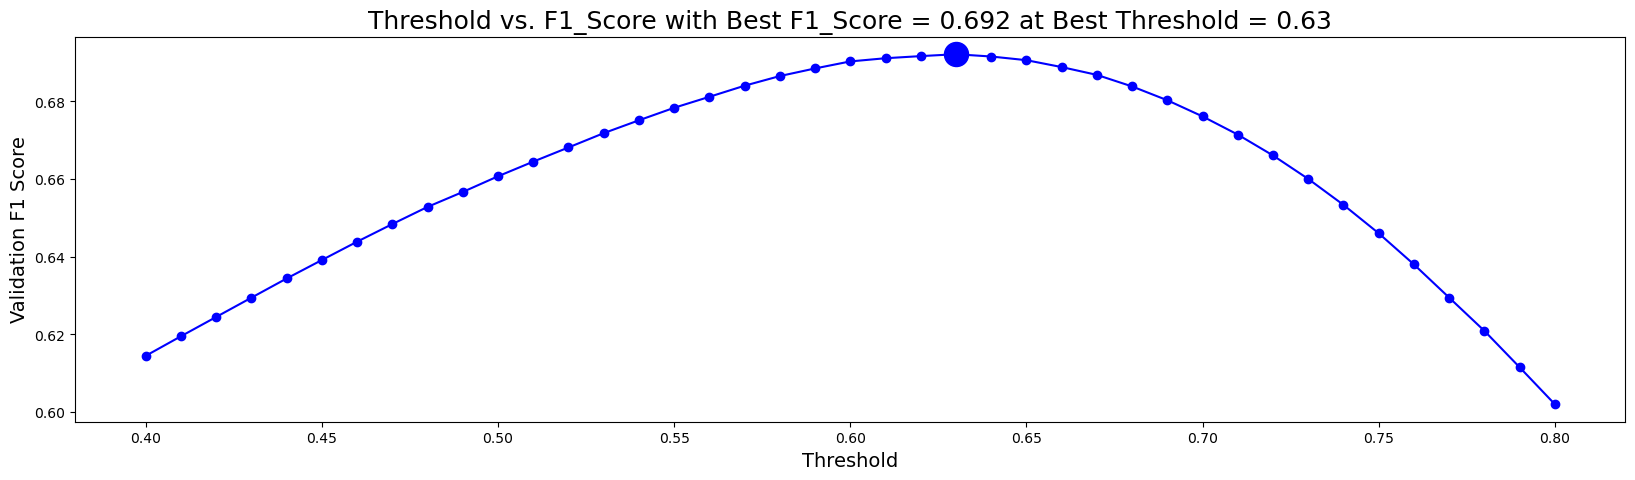

In [101]:
# stealing a plot from another person, but it looks nice

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, "-o", color="blue")
plt.scatter([best_threshold], [best_score], color="blue", s=300, alpha=1)
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score", size=14)
plt.title(
    f"Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}",
    size=18,
)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

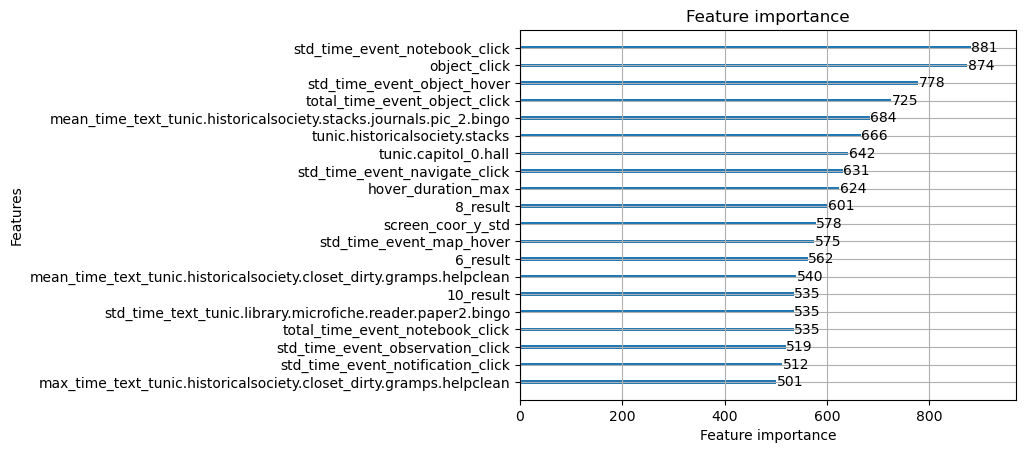

In [104]:
lgb.plot_importance(models['question_13_fold_4'], max_num_features=20)

In [102]:
def prep_data(df=None):
    "how to prep the data for the kaggle notebook"
    
    level_dict = {
        '0-4' : [1, 2, 3],
        '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        '13-22' : [14, 15, 16, 17, 18]
    }

    
    df_ = df.copy()
        
    
    # getting elapsed diffs
    df_['event_time_delta'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: x.diff().fillna(x.min()))
        .clip(0, 10000)
    )

    # getting the time until the next event
    df_['time_delta_til_next'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: abs(x.diff(-1)).fillna(abs(x.min())))
        .clip(0, 10000)
    )
    
    # room coord stats
    screen_coor_stats = df_.groupby('session_id').agg(screen_coor_x_mean=('screen_coor_x', 'mean'),
                                                      screen_coor_x_std=('screen_coor_x', 'std'),
                                                      screen_coor_y_mean=('screen_coor_y', 'mean'),
                                                      screen_coor_y_std=('screen_coor_y', 'std'),
                                                      manhat_screen_mean=('screen_manh_distance', 'mean'),
                                                      manhat_screen_std=('screen_manh_distance', 'std'))
    
    # time delta stats    
    time_delta_stats = df_.groupby('session_id').agg(event_time_mean=('event_time_delta', 'mean'),
                                                    event_time_std=('event_time_delta', 'std'),
                                                    event_time_max=('event_time_delta', 'max'))
    
    # hover duration stats
    hover_duration_stats = df_.groupby('session_id').agg(hover_duration_mean=('hover_duration', 'mean'),
                                                        hover_duration_std=('hover_duration', 'std'),
                                                        hover_duration_max=('hover_duration', 'max'))
    
    # get last 4 fqid
    fqid_df = df_.groupby('session_id')['fqid'].apply(get_last_6).reset_index()
    fqid_df['entry_number'] = fqid_df.groupby('session_id').cumcount() + 1

    final_fqid = (
        fqid_df
        .pivot(index='session_id',
               columns='entry_number',
               values='fqid')
        .rename(columns={1:'fqid_1back', 2:'fqid_2back', 3:'fqid_3back', 4:'fqid_4back',
                         5: 'fqid_5back', 6: 'fqid_6back'})
    )
                                                                                                   
    # total time on each event
    total_time_event = (
        df_
        .groupby(['session_id', 'event_name'])
        .agg(total_time_event=('time_delta_til_next', 'sum'),
             std_time_event=('time_delta_til_next', 'std'))
        .unstack()
    )
    
    # total time on each text id    
    total_time_text = (
        df_
        .groupby(['session_id', 'text_fqid'])
        .agg(total_time_text=('event_time_delta', 'sum'),
             mean_time_text=('event_time_delta', 'mean'),
             std_time_text=('event_time_delta', 'std'))
        .unstack()
    )
    
    
    # unique fqids 
    nunique_fqid = df_.groupby('session_id')['fqid'].nunique()
    
    # unique rooms
    nunique_rooms = df_.groupby('session_id')['room_fqid'].nunique()
    
    # total time in rooms
    time_in_rooms = (
        df_
        .groupby(['session_id', 'room_fqid'])['time_delta_til_next']
        .sum()
        .unstack()
    )
    
    # notebook opens
    notebook_opens = (
        df_.groupby(['session_id'])['name']
        .value_counts()
        .unstack()['open']
        .rename('notebook_opens')
    )
    
    # unique text ids
    nunique_text_ids = df_.groupby('session_id')['text_fqid'].nunique()
    
    # unique texts
    nunique_text = df_.groupby(['session_id'])['text'].nunique()    
    
    # how many events of each type occurred in the session
    event_counts = df_.groupby('session_id')['event_name'].value_counts().unstack()
    
    # page counts
    page_counts = df_.groupby('session_id')['page'].value_counts().unstack().fillna(0)
    page_counts.columns = [f'page_{x}' for x in page_counts.columns]
    
    # getting session lengths
    session_lengths = df_.groupby('session_id')['elapsed_time'].max().rename('total_length')
    
    # total events in the session
    session_events = df_.groupby('session_id')['session_id'].count().rename('total_events')
    
    # final df pre labels
    df_features = (
        pd.concat([total_time_event, nunique_fqid, event_counts,
                   session_lengths, session_events, time_delta_stats,
                   hover_duration_stats, page_counts, nunique_rooms, time_in_rooms,
                   nunique_text_ids, screen_coor_stats, total_time_text,
                   nunique_text, notebook_opens, final_fqid], axis=1)
    )
    
    bad_cols = ['year', 'checkpoint', 'weekend', 'fqid', 'notification_click',  
                'cutscene_click', 'observation_click']
    
    feature_cols = [col for col in df_features.columns if col not in bad_cols]
    
    CAT_FEATURES = ['fqid_1back', 'fqid_2back', 'fqid_3back', 'fqid_4back',
                    'fqid_5back', 'fqid_6back']
    
    df_features[CAT_FEATURES] = df_features[CAT_FEATURES].astype(object).fillna("NA")
    
    return df_features, feature_cols

In [21]:
# saving models
for key in models.keys():
    
    model_ = models[key]
    
    with open(f'models/model_{key}.pickle', 'wb') as file:
        pickle.dump(model_, file, protocol=4)

In [ ]:
# saving features
with open('feature_cols_may17.pickle', 'wb') as file:
    pickle.dump(feature_cols, file, protocol=4)

In [50]:
test_df = df[(df['session_id'] == 20090312431273200) & (df['level_group'] == '0-4')].copy()

tf, feature_tf = prep_data(df = test_df)

In [19]:
# loading models for test

models = {}

for filename in os.listdir('models'):
    if 'fold_4' in filename:
        with open(f'models/{filename}', 'rb') as file:
            name = filename.split('.')[0]
            model_ = pickle.load(file)
            models[name] = model_

In [142]:
# this cell iterates over the test data 
test_df = pd.read_csv('test.csv')

# simple distance calculation
test_df['room_distance'] = np.sqrt(test_df['room_coor_x'] ** 2 + test_df['room_coor_y'] ** 2)
test_df['screen_distance'] = np.sqrt(test_df['screen_coor_x'] ** 2 + test_df['screen_coor_y'] ** 2)

# simple manhattan distance calc (worked)
test_df['screen_manh_distance'] = abs(test_df['screen_coor_x']) + abs(test_df['screen_coor_y'])

# defining the questions for each group
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for _, tf in test_df.groupby(['session_id', 'level_group']):
    print('hello')
    
    # get the level group (to get the data for the model)
    level_group = tf['level_group'].values[0]
    
    # create feature test_df
    test_df_, feature_cols_ = prep_data(tf)
    
    # figure out if feature columns are missing - important for submission
    missing_columns = list(set(group1_features) - set(test_df_.columns))
    
    # create a dataframe with the missing columns filled with 0s (for now)
    missing_test_df = pd.DataFrame(0, columns=missing_columns, index=test_df_.index)
    
    # combine the original test_df and the missing test_df
    test_df_ = pd.concat([test_df_, missing_test_df], axis=1)
    print("test_df shape is:", test_df_.shape)
    
    # get the questions to iterate over
    a, b = limits[level_group]  
    
    for question in range(a, b):
        # getting model and threshold for the question
        model_ = models[f'question_{question}_fold_2']
        feature_names = models['question_1_fold_0'].feature_names_
        threshold = 0.63
        
        test_df_.columns = [str(x) for x in test_df_.columns]
        test_df_.columns 
        
        print(list(set(test_df_[feature_names].columns) - set(feature_names)))
        raw_pred_proba = model_.predict_proba(test_df_[feature_names])[0, 1]
        final_pred = (raw_pred_proba > threshold).astype(int)
    
        print(final_pred)

hello
test_df shape is: (1, 457)
[]
1
[]


C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:72: Feature 1_result is present in model but not in pool.

In [110]:
test_df_[feature_cols_]

,"(total_time_event, checkpoint)","(total_time_event, cutscene_click)","(total_time_event, map_click)","(total_time_event, map_hover)","(total_time_event, navigate_click)","(total_time_event, notebook_click)","(total_time_event, notification_click)","(total_time_event, object_click)","(total_time_event, object_hover)","(total_time_event, observation_click)",...,"(std_time_text, tunic.kohlcenter.halloffame.plaque.face.date)","(std_time_text, tunic.kohlcenter.halloffame.togrampa)",text,notebook_opens,fqid_1back,fqid_2back,fqid_3back,fqid_4back,fqid_5back,fqid_6back
session_id,,,,,,,,,,,,,,,,,,,,,
20090109393214576,0.0,47262.0,5416.0,2882.0,95393.0,9592.0,6635.0,13567.0,3515.0,3976.0,...,364.867099,789.838275,53,2,toentry,NA,toentry,tunic.capitol_0,chap1_finale,chap1_finale_c


In [174]:
importances = models['question_4_fold_0'].feature_importances_.round(3)
sorted_index = np.argsort(importances)[::-1]
names = models['question_4_fold_0'].feature_names_

for key in models.keys():
    
    model = models[key]
    fi = model.feature_importances_.round(3)
    mask = np.where(fi > 0)[0]
    
    columns = [x for i, x in enumerate(model.feature_names_) if i in mask]
    
    print(print(columns))

["('total_time_event', 'cutscene_click')", "('total_time_event', 'map_click')", "('total_time_event', 'map_hover')", "('total_time_event', 'navigate_click')", "('total_time_event', 'notebook_click')", "('total_time_event', 'notification_click')", "('total_time_event', 'object_click')", "('total_time_event', 'object_hover')", "('total_time_event', 'observation_click')", "('total_time_event', 'person_click')", "('std_time_event', 'checkpoint')", "('std_time_event', 'cutscene_click')", "('std_time_event', 'map_click')", "('std_time_event', 'map_hover')", "('std_time_event', 'navigate_click')", "('std_time_event', 'notebook_click')", "('std_time_event', 'notification_click')", "('std_time_event', 'object_click')", "('std_time_event', 'object_hover')", "('std_time_event', 'observation_click')", "('std_time_event', 'person_click')", 'map_click', 'map_hover', 'navigate_click', 'notebook_click', 'object_click', 'object_hover', 'person_click', 'total_length', 'total_events', 'event_time_mean', 

In [124]:
a, b = prep_data(test_df[(test_df['session_id'] == 20090109393214576) & (test_df['level_group'] == '0-4')])

In [125]:
a.shape

(1, 105)